This notebook mainly implements the **Structured Low-Rank Matrix Completion (SLRMC)** of the following paper:

Jonathan Gillard, Konstantin Usevich (2018). Structured low-rank matrix completion for forecasting in time series analysis. arXiv:1802.08242.

Technical highlights:

- Embed a time series into a Hankel matrix and the missing data (to be forecasted) are stored in the bottom right-hand corner of this matrix.
- Consider a matrix completion problem for Hankel matrices.
- Choose a proper weighting scheme for the known observations.

In [1]:
import numpy as np
from numpy.linalg import inv as inv

The solution of problem
\begin{equation}
\begin{aligned}
&\min_{\boldsymbol{x}\in\mathbb{R}^{(m+n)}}~\|\mathcal{S}(\boldsymbol{x})\|_{*} \\
&\text{s.t.}~\boldsymbol{x}_{[1:n]}=\boldsymbol{y}, \\
\end{aligned}
\end{equation}
is given by

1) Construct the scaled initial data vector $\tilde{\boldsymbol{y}}$ as
$$\tilde{\boldsymbol{y}}=\left(y_1\cdot\operatorname{exp}\left(\frac{\alpha}{2}\right),y_2\cdot\operatorname{exp}\left(\frac{2\alpha}{2}\right),\cdots,y_n\cdot\operatorname{exp}\left(\frac{n\alpha}{2}\right)\right),$$
for a given $\alpha$.

2) Solve the problem
$$\begin{aligned}
&\min_{\boldsymbol{x}\in\mathbb{R}^{(m+n)}}~\|\mathcal{S}(\boldsymbol{x})\|_{*} \\
&\text{s.t.}~\boldsymbol{x}_{[1:n]}=\tilde{\boldsymbol{y}}. \\
\end{aligned}
$$

3) Scale back the weighted values
$$\hat{\boldsymbol{y}}=\left(x_1\cdot\operatorname{exp}\left(-\frac{\alpha}{2}\right),x_2\cdot\operatorname{exp}\left(-\frac{2\alpha}{2}\right),\cdots,x_n\cdot\operatorname{exp}\left(-\frac{n\alpha}{2}\right),\cdots,x_{m+n}\cdot\operatorname{exp}\left(-\frac{(m+n)\alpha}{2}\right)\right).$$

In [2]:
def scale_to_data(vec, alpha):
    dim = vec.shape[0]
    new_vec = np.zeros(dim)
    for i in range(dim):
        new_vec[i] = vec[i] * np.exp((i + 1) * alpha / 2)
    return new_vec

def scale_back_data(vec, alpha):
    dim = vec.shape[0]
    new_vec = np.zeros(dim)
    for i in range(dim):
        new_vec[i] = vec[i] * np.exp(- (i + 1) * alpha / 2)
    return new_vec

What is structured low-rank matrix completion?

In [3]:
def hankel(vec, window_length):
    column_num = vec.shape[0] - window_length + 1
    hankel_mat = np.zeros((window_length, column_num))
    for i in range(window_length):
        hankel_mat[i, :] = vec[i : column_num + i]
    return hankel_mat

def hankel2vec(mat):
    dim1, dim2 = mat.shape
    new_mat = np.zeros((dim1, dim1 + dim2 - 1))
    for i in range(dim1):
        new_mat[i, i : dim2 + i] = mat[i, :]
    return np.true_divide(new_mat.sum(0), (new_mat != 0).sum(0))

def svt(mat, tau):
    [m,n] = mat.shape
    if 2 * m < n:
        u, s, v = np.linalg.svd(mat @ mat.T, full_matrices = 0)
        s = np.sqrt(s)
        tol = n * np.finfo(float).eps * np.max(s)
        idx = np.sum(s > max(tau, tol))
        mid = (s[:idx] - tau) / s[:idx]
        return (u[:,:idx] @ np.diag(mid)) @ (u[:,:idx].T @ mat)
    elif m > 2 * n:
        return svt(mat.T, tau).T
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    idx = np.sum(s > tau)
    return u[:,:idx] @ np.diag(s[:idx]-tau) @ v[:idx,:]
    
def SLRMC(vec, window_length, forecast_horizon, rho, maxiter):
    mat = hankel(np.append(vec, np.zeros(forecast_horizon)), window_length)
    pos_missing = np.where(mat == 0)
    dim1, dim2 = mat.shape
    T = np.zeros((dim1, dim2))
    Z = mat.copy()
    for it in range(maxiter):
        X = svt(Z - T / rho, 1 / rho)
        Z[pos_missing] = (X + T / rho)[pos_missing]
        T = T + rho * (X - Z)
        vec_hat = hankel2vec(X)
    return vec_hat

Toy example: forecast $\boldsymbol{y}=\left(1,2,3,4,5,6,?,?\right)$ where we assume that the last two values are 7 and 8 (i.e., ground truth).

Ready? Let us do it!

In [4]:
y = np.array([1, 2, 3, 4, 5, 6])
alpha = - 1 / 2
window_length = 5
forecast_horizon = 2
rho = 0.1
maxiter = 200
y_tilde = scale_to_data(y, alpha)
x = SLRMC(y_tilde, window_length, forecast_horizon, rho, maxiter)
y_hat = scale_back_data(x, alpha)
print('Original data sequence:')
print(y)
print()
print('Forecasted data sequence:')
print(y_hat)

Original data sequence:
[1 2 3 4 5 6]

Forecasted data sequence:
[1.00016074 1.9998642  2.99993493 4.00004691 5.00041026 5.99939527
 6.99627719 7.9884971 ]


/var/folders/5d/p9vn920s48q67rgbvw9p_1km0000gn/T/ipykernel_12070/267474528.py:13: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(new_mat.sum(0), (new_mat != 0).sum(0))


This rather obvious sequence can be easily forecasted. But how about more complicated sequences?

In [5]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
data = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])[0, - 9 * 144 :]

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

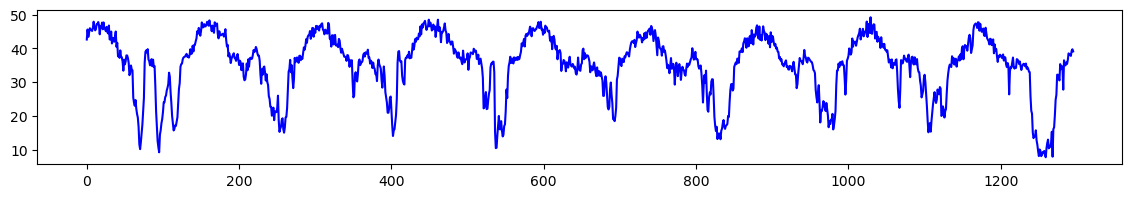

In [8]:
fig = plt.figure(figsize = (14, 2))
plt.plot(data, color = "b")
plt.show()

In [9]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

/var/folders/5d/p9vn920s48q67rgbvw9p_1km0000gn/T/ipykernel_12070/474878816.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_hat = np.zeros(np.int(steps * forecast_horizon))
/var/folders/5d/p9vn920s48q67rgbvw9p_1km0000gn/T/ipykernel_12070/474878816.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

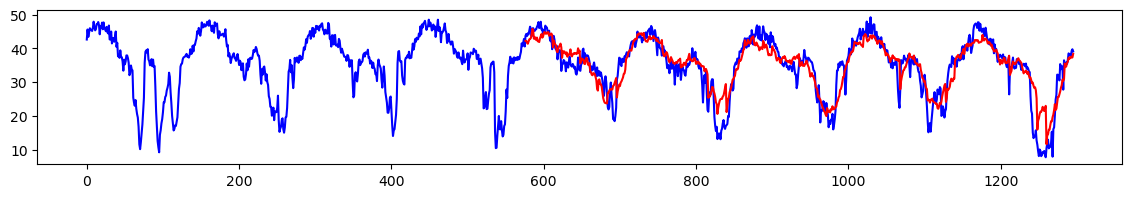

Prediction MAPE: 0.129854
Prediction RMSE: 4.22777
Running time: 192 seconds


In [10]:
import time
start = time.time()
steps = 5 * 144 / 12
alpha = - 0.005
window_length = 144
forecast_horizon = 12
rho = 0.05
maxiter = 200

data_hat = np.zeros(np.int(steps * forecast_horizon))
for i in range(np.int(steps)):
    y = data[: 4 * 144 + 12 * i]
    y_tilde = scale_to_data(y, alpha)
    x = SLRMC(y_tilde, window_length, forecast_horizon, rho, maxiter)
    y_hat = scale_back_data(x, alpha)
    data_hat[forecast_horizon * i : forecast_horizon * (i + 1)] = y_hat[- forecast_horizon :]
    
    if (i + 1) % 60 == 0:
        fig = plt.figure(figsize = (14, 2))
        plt.plot(data, color = "b")
        plt.plot(np.arange(4 * 144, 9 * 144), data_hat, color = 'r')
        plt.show()

mape = compute_mape(data[4 * 144 :], data_hat)
rmse = compute_rmse(data[4 * 144 :], data_hat)
print('Prediction MAPE: {:.6}'.format(mape))
print('Prediction RMSE: {:.6}'.format(rmse))
end = time.time()
print('Running time: %d seconds'%(end - start))

This is a case of single time series forecasting. How about multivariate time series forecasting?